In [41]:
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import time
import math

In [2]:
sns.set_theme()

# h - Jacobi polynomials

In [38]:
def aHelper(alpha, beta, n1, n2):
    if n1 == -1 and n2 == 0:
        return 0
    
    elif n1 == n2 - 1 and n2 > 0:
        return 2 * (n2 + alpha) * (n2 + beta) / ((2*n2 + alpha + beta + 1) * (2*n2 + alpha + beta))
    
    elif n1 == n2:
        return (alpha**2 - beta**2) / ((2*n2 + alpha + beta + 2) * (2*n2 + alpha + beta))
    
    elif n1 == n2 + 1:
        return 2 * n1 * (n1 + alpha + beta) / ((2*n2 + alpha + beta + 2) * (2*n2 + alpha + beta + 1))
    
    else:
        raise ValueError("Invalid n1, n2 combination in aHelper")

def JacobiP(x, alpha, beta, n):
    if n == 0:
        return np.ones_like(x)
    elif n == 1:
        return 1/2 * (alpha - beta + x * (alpha + beta + 2))
    else:
        return ((aHelper(alpha, beta, n-1, n-1) + x) * JacobiP(x, alpha, beta, n-1) 
                - aHelper(alpha, beta, n-2, n-1) * JacobiP(x, alpha, beta, n-2)) / aHelper(alpha, beta, n, n-1)

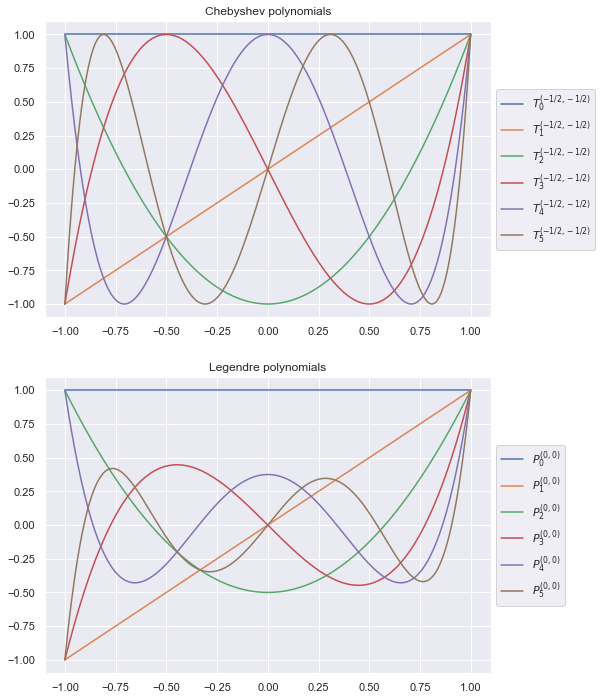

In [40]:
# Plotting
fig, axs = plt.subplots(2, 1, figsize=(8,12))

x = np.linspace(-1, 1, 250)

for n in range(6):
    axs[0].plot(x, scipy.special.gamma(n+1)* scipy.special.gamma(1/2) / scipy.special.gamma(n+1/2) * JacobiP(x, -1/2, -1/2, n), label=fr"$T_{n}^{{(-1/2, -1/2)}}$")
    axs[1].plot(x, JacobiP(x, 0, 0, n), label=fr"$P_{n}^{{(0,0)}}$")


axs[0].set_title("Chebyshev polynomials")
axs[1].set_title("Legendre polynomials")
axs[0].legend(loc="center left", bbox_to_anchor=(1, 0.5))
axs[1].legend(loc="center left", bbox_to_anchor=(1, 0.5))